# Exercise 3.1
### Generation of MNIST digits with a GAN

First we import the modules we need

In [103]:
import numpy as np
from tqdm import tqdm_notebook as tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from IPython import display
import matplotlib.pylab as plt
import ipywidgets

In [104]:
if torch.cuda.is_available():
    print("The code will run on GPU. This is important so things run faster.")
else:
    print("The code will run on CPU. You should probably not do this.")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU. This is important so things run faster.


In [105]:
batch_size = 64
trainset = datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1)
testset = datasets.MNIST('./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=1)

Implement your **generator** network as a fully connected neural network

Start out with a network that:
* takes as input 100 Normally distributed numbers
* has four hidden layers with 4096 neurons
* uses LeakyReLU as the activation function
* uses BatchNorm
* has Tanh as the last layer (we work with MNIST in the -1 to 1 range)

In [106]:
class G(nn.Module):
    def __init__(self):
        super(G, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(100, 4096),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(4096),
            nn.Linear(4096,4096),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(4096),
            nn.Linear(4096,4096),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(4096),
            nn.Linear(4096,4096),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(4096),
            nn.Linear(4096,784),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), 1, 28, 28)
        return x

Implement your **discriminator** network as a fully connected neural network

Start out with a network that
* takes as input an $28\times28$ image
* has three hidden layers with [1024, 512, 256] neurons respectively
* uses LeakyReLU as the activation function
* uses Dropout
* has Tanh as the last layer (we work with MNIST in the -1 to 1 range)

In [107]:
class D(nn.Module):
    def __init__(self):
        super(D, self).__init__()       
        self.discriminator = nn.Sequential(
            nn.Linear(784,1024),
            nn.LeakyReLU(0.1),
            nn.Dropout(p=0.5),
            nn.Linear(1024,512),
            nn.LeakyReLU(0.1),
            nn.Dropout(p=0.5),
            nn.Linear(512,256),
            nn.LeakyReLU(0.1),
            nn.Dropout(p=0.5),
            nn.Linear(256,1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.discriminator(x)
        return x

## DCGAN

In [151]:
class DCGAN_G(nn.Module):
    def __init__(self):
        super(DCGAN_G, self).__init__()
        self.fc = nn.Sequential(
            nn.ConvTranspose2d(100, 128, 3, stride=2), # 1->3
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 256, 3, stride=2),# 3->7
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 512, 2, stride=2),# 7->14
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(512),
            nn.ConvTranspose2d(512, 1024, 2, stride=2),# 14->28
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(1024),
            nn.Conv2d(1024, 1, 3, stride=1, padding = 1),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = x.view(x.size(0), x.size(1), 1, 1)
        x = self.fc(x)
#         x = x.view(x.size(0), 1, 28, 28)
        return x

class DCGAN_D(nn.Module):
    def __init__(self):
        super(DCGAN_D, self).__init__()   
        self.cnn0 = nn.Sequential(
            nn.Conv2d(1, 512, 3, stride = 2, padding = 1), # 28 -> 14
            nn.LeakyReLU(0.1),
            nn.Dropout(p=0.5)
#             nn.BatchNorm2d(128),
        )
        
        self.cnn1 = nn.Sequential(
            nn.Conv2d(512,256,3, stride = 2, padding = 1), # 14-> 7
            nn.LeakyReLU(0.1),
            nn.Dropout(p=0.5)
#             nn.BatchNorm2d(256)
        )
        
        self.cnn2 = nn.Sequential(
            nn.Conv2d(256,128,7, stride = 1, padding = 0), # 7 -> 1
            nn.LeakyReLU(0.1),
            nn.Dropout(p=0.5)
#             nn.BatchNorm2d(512)
        )
        
        self.discriminator = nn.Sequential(
            nn.Conv2d(128,1,1, stride = 1, padding = 0), # 1 -> 1
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.cnn0(x)
        x = self.cnn1(x)
        x = self.cnn2(x)
        x = self.discriminator(x)
        return x

## Loss Function Section

In [152]:
def vanilla_loss_d(dx, dz):    
    ## dx dz have passed sigmoid, range from 0 to 1
    return -(torch.mean(torch.log(dx)) + torch.mean(torch.log(1-dz)))
#     return torch.mean(-dx + torch.log(torch.exp(dx)+1)+torch.log(torch.exp(dz)+1))

def vanilla_loss_g(dz):
    ## dx dz have passed sigmoid, range from 0 to 1
    return -torch.mean(torch.log(dz))
#     return torch.mean(torch.log(torch.exp(-dz)+1))

In [153]:
def wgan_loss_d(dx, dz):
    return -(torch.mean(dx) - torch.mean(dz))

def lsgan_loss_d(dx, dz):
    b = 1
    return 0.5*torch.mean((dx - b)**2)+0.5*torch.mean((dz)**2)

def lsgan_loss_g(dz):
    c = 1
    return 0.5*torch.mean((dz-c)**2)

In [ ]:
def cgan_loss_d(dx, dz, target):
    ## use soft-max
    
    pass

def cgan_loss_g(dz, y):
    pass

Output()

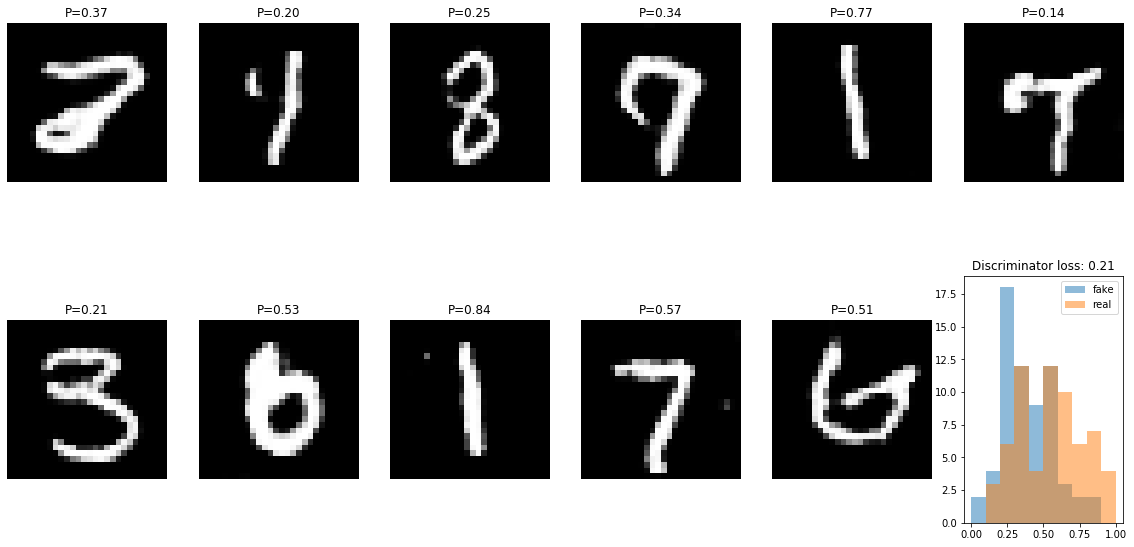

In [154]:
useDCGAN = True
if useDCGAN == True:
    #Initialize networks
    d = DCGAN_D().to(device)
    g = DCGAN_G().to(device)
else:
    #Initialize networks
    d = D().to(device)
    g = G().to(device)


losstype = 1
if losstype == 1:
    cost_d = lsgan_loss_d
    cost_g = lsgan_loss_g
elif losstype == 2:
    cost_d = vanilla_loss_d
    cost_g = vanilla_loss_g

#d_opt = torch.optim.SGD(d.parameters(), 0.002, momentum=0.9)
d_opt = torch.optim.Adam(d.parameters(), 0.0002, (0.5, 0.999))
g_opt = torch.optim.Adam(g.parameters(), 0.0001, (0.5, 0.999))

#Clean up all old variables on the GPU no longer in use
torch.cuda.empty_cache()

visualization = ipywidgets.Output()
display.display(visualization)

with visualization:
    plt.figure(figsize=(20,10))
subplots = [plt.subplot(2, 6, k+1) for k in range(12)]
num_epochs = 10
for epoch in tqdm(range(num_epochs), unit='epoch'):
    for minibatch_no, (x, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        x = x.to(device)*2-1
        
        #Update Discriminator
        z = torch.randn(x.shape[0], 100).to(device)
        d.zero_grad()
        with torch.no_grad(): #We don't need gradients for G when we update D
            xhat = g(z)
        d_loss=cost_d(d(x), d(xhat))
        
        d_loss.backward()
        d_opt.step()

        #Update Generator
        z = torch.randn(batch_size, 100).cuda()
        g.zero_grad()
        xhat = g(z)
        g_loss = cost_g(d(xhat))
        g_loss.backward()
        g_opt.step()
        
        assert(not np.isnan(d_loss.item()))
        #Plot every 100 minibatches
        if minibatch_no % 100 == 0:
            with torch.no_grad(), visualization:
                P = (d(xhat))
                for k in range(11):
                    xhat_k = xhat[k].cpu().squeeze()/2+.5
                    subplots[k].imshow(xhat_k, cmap='gray')
                    subplots[k].set_title('P=%.2f' % P[k])
                    subplots[k].axis('off')

                H1 = d(g(torch.randn(batch_size, 100).to(device)))
                H2 = d(x)
               
                subplots[11].cla()
                subplots[11].hist(H1.cpu().squeeze(), label='fake', range=(0, 1), alpha=0.5)
                subplots[11].hist(H2.cpu().squeeze(), label='real', range=(0, 1), alpha=0.5)
                subplots[11].legend()
                subplots[11].set_title('Discriminator loss: %.2f' % d_loss.item())

                display.display(plt.gcf())
                display.clear_output(wait=True)
                

Did you get a model to generate nice images?
Consider these
# Additional tasks
* Implement another loss - **done**
* Convert your network to a DCGAN - **done**
* Generate images from FashionMNIST
* Convert your architecture into a cGAN
* Hard: Create a cGAN model to convert from SVHN to MNIST

In [16]:
print(np.log(0.2))

-1.6094379124341003


## FashionMNIST

### my initial implementation: hope it will work.

In [155]:
# download
batch_size = 64
fashion_trainset = datasets.FashionMNIST('./data', train=True, download=True, 
                                         transform=transforms.ToTensor())
fashion_train_loader = DataLoader(fashion_trainset, 
                                  batch_size=batch_size, 
                                  shuffle=True, num_workers=1)
fashion_testset = datasets.FashionMNIST('./data', train=False, download=True, 
                                        transform=transforms.ToTensor())
fashion_test_loader = DataLoader(fashion_trainset, 
                                 batch_size=batch_size, 
                                 shuffle=False, num_workers=1)


0it [00:00, ?it/s]

26427392it [00:01, 16751574.62it/s]                              


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 357929.79it/s]
0it [00:00, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz


4423680it [00:00, 11086137.57it/s]                           
0it [00:00, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 118741.45it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [156]:
if torch.cuda.is_available():
    print("The code will run on GPU. This is important so things run faster.")
else:
    print("The code will run on CPU. You should probably not do this.")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


The code will run on GPU. This is important so things run faster.


In [ ]:
useDCGAN = True
if useDCGAN == True:
    #Initialize networks
    d = DCGAN_D().to(device)
    g = DCGAN_G().to(device)
else:
    #Initialize networks
    d = D().to(device)
    g = G().to(device)
    

losstype = 1
if losstype == 1:
    cost_d = lsgan_loss_d
    cost_g = lsgan_loss_g
elif losstype == 2:
    cost_d = vanilla_loss_d
    cost_g = vanilla_loss_g

#d_opt = torch.optim.SGD(d.parameters(), 0.002, momentum=0.9)
d_opt = torch.optim.Adam(d.parameters(), 0.0002, (0.5, 0.999))
g_opt = torch.optim.Adam(g.parameters(), 0.0001, (0.5, 0.999))

#Clean up all old variables on the GPU no longer in use
torch.cuda.empty_cache()

visualization = ipywidgets.Output()
display.display(visualization)

with visualization:
    plt.figure(figsize=(20,10))
subplots = [plt.subplot(2, 6, k+1) for k in range(12)]
num_epochs = 10
for epoch in tqdm(range(num_epochs), unit='epoch'):
    for minibatch_no, (x, target) in tqdm(enumerate(fashion_train_loader), total=len(fashion_train_loader)):
        x = x.to(device)*2-1
        
        #Update Discriminator
        z = torch.randn(x.shape[0], 100).to(device)
        d.zero_grad()
        with torch.no_grad(): #We don't need gradients for G when we update D
            xhat = g(z)
        d_loss=cost_d(d(x), d(xhat))
        
        d_loss.backward()
        d_opt.step()

        #Update Generator
        z = torch.randn(batch_size, 100).cuda()
        g.zero_grad()
        xhat = g(z)
        g_loss = cost_g(d(xhat))
        g_loss.backward()
        g_opt.step()
        
        assert(not np.isnan(d_loss.item()))
        #Plot every 100 minibatches
        if minibatch_no % 100 == 0:
            with torch.no_grad(), visualization:
                P = (d(xhat))
                for k in range(11):
                    xhat_k = xhat[k].cpu().squeeze()/2+.5
                    subplots[k].imshow(xhat_k, cmap='gray')
                    subplots[k].set_title('P=%.2f' % P[k])
                    subplots[k].axis('off')

                H1 = d(g(torch.randn(batch_size, 100).to(device)))
                H2 = d(x)
               
                subplots[11].cla()
                subplots[11].hist(H1.cpu().squeeze(), label='fake', range=(0, 1), alpha=0.5)
                subplots[11].hist(H2.cpu().squeeze(), label='real', range=(0, 1), alpha=0.5)
                subplots[11].legend()
                subplots[11].set_title('Discriminator loss: %.2f' % d_loss.item())

                display.display(plt.gcf())
                display.clear_output(wait=True)
                

Output()